# Wall Street Bandits

Quick and simple one this week. We will use reinforcement learning in the Multi-Armed Bandit paradigm in order to select a stock trading bot with the best performance. 

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import tensorflow as tf
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x):
        return x # sub out TQDM if it isn't installed, since it isn't strictly necessary. Just shiny. 

import preprocess # this is necessary for data i/o

#### First, let us define a generic parent class with necessary functions, so we can subclass later with the specific bots. OOP FTW!

In [3]:
class BanditBot:
    name = 'BaseBot'
    inflation_loss = 0.995 # Due to inflation, holding on to cash is equivalent to losing money. We coarsely simulate this with this parameter
    def __init__(self, roi=1., bankroll=1., nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        self.roi = roi # Return on Investment - used to calculate Buy And Hold strategy
        self.bankroll = bankroll # needed to determine how much we can short
        self.p = p # our principle 
        self.q = q # amount of stock
        self.p0 = p # save the initial bankroll for reset
        self.q0 = q 
        self.r_buy = r_buy # the ratio of p to spend on purchase 
        self.r_sell = r_sell # the ratio of p to liquidate on sell
        self.nt = nt # length of input vector
        
        self.p_margin = 0 # in development
        self.q_margin = 0
        
    def buy(self, x, t):
        '''Buy at time index t at value x[t]'''
        p_spent = self.p * self.r_buy
        q_bought = p_spent / x[t]
        self.q += q_bought
        self.p -= p_spent
        return (p_spent, q_bought)
    
    def sell(self, x, t):
        '''Sell at time index t at value x[t]'''
        q_sold = self.q * self.r_sell 
        p_earned = q_sold * x[t]
        self.q -= q_sold
        self.p += p_earned
        return (p_earned, q_sold)
    
    def short_position(self, x, t1, t2):
        '''The noble short sell. "Borrow" stock in order to sell it immediately, then buy it back at a later date in order return the borrowed shares.
        '''
        q_short = self.bankroll / x[t1] # decide the amount we want to short, since in theory can short infinite
        self.q_margin += q_short
        p_earned = q_short * x[t1]
        self.p += p_earned
        
        q_return = self.q_margin
        p_buyback = q_return * x[t2]
        self.q_margin -= q_return
        self.p -= p_buyback
        return (p_earned-p_buyback, q_short)
        
        
    def liquidate(self, x):
        '''Sell all positions so we are left only with cash'''
        q_sold = self.q
        p_earned = q_sold * x[-1]
        self.q = 0
        self.p += p_earned
        return (p_earned, q_sold)
    
    def score(self, x):
        '''Liquidate all shares at current market price and then compute how much money we made.
        For the reinforcement paradigm to work well, we define score == 0 as neither gained nor lost any money this round'''
        self.liquidate(x)
        return float((self.roi * self.inflation_loss * self.p) - self.p0)
    
    def reset(self):
        '''Set funds back to original bankroll'''
        self.p = self.p0
        self.q = self.q0
        
        
    def __call__(self, x, *args, **kwargs):
        '''We will use the call protocol to represent running the bot on a single epoch. This will be overloaded for each subclass. Just a fancy little convenience.
            reward = bot()
        would be the same as: 
            reward = bot.pullBandit()
        '''
        result = np.random.randn(1)
        if result > 0:
            return 1 #return a positive reward.
        else:
            return -1 #return a negative reward.
        

## Let's meet our contenders!
* Images are used as thumbnails with fair use in mind for variety and educational purpose only, their respective copyright holders retain copyright*

### The Wimp
![sir robin](images/robin.jpg)
Cowardly refuses to invest in the market. It's too risky for him. This will serve as our baseline to control for effects like inflation. 
*When danger reared its ugly head, he bravely turned his tail and fled!*

### Buy and Hold
![buffet](images/buffet.jpg) 
The classic strategy. Buy an instrument with good fundamentals and just hold on to it for a long period of time. This works well because the markets are demonstrated to consistently increase in value when averaged over long periods of time. My money's on this one. 

### The Bull
![bull and girl](images/girlandbull.jpg)
We expect the market to do well on average. Buy at the start of the time frame and sell at the end of it. However, this involves more trades than the Buy and Hold

### The Bear
![bear](images/bear.jpg)
We are pessimistic and expect the market to go down. Shortsell right off the bat. I don't expect this bot to perform well, it's mostly to test the short functionality.


### Strategic Bull
We expect the market to *generally* do well, but not all the time. Check the first N datapoints for an overall trend. If it's upward, buy in and sell at the end of the period. 

### Strategic Bear
We expect the market to *generally* do well, but not all the time. Check the first N datapoints for an overall trend. If it's downward, shortsell until the end of the period. 


### Bull/Bear strategic trend
![bullbear](images/bullbear.jpg)
We expect the market to *generally* do well, but not all the time. Check the first N datapoints for an overall trend. If it's upward, buy in. If it's downward, shortsell. Liquidate at the end of the period. 


### The Monkey
![blindmonkey](images/blindmonkey.jpg)
> *A blindfolded monkey throwing darts at a newspaper's financial pages could select a portfolio that would do just as well as one carefully selected by experts* - Burton Malkiel

Basically, an RNG. If Burton Malkiel is correct, this should do just as well as any hedge fund manager. Champagne and yatchs, here we come!

### The YOLOer / WSB
![wsb](images/wsb.jpg)
Like the monkey, only riskier. Randomly buys and sells AND randomly short sells. You think simple Buy and Hold will get you a yatch?

In [4]:
class TheWimp(BanditBot):
    name = 'TheWimp'
    # Cowardly refuses to spend any money! Aka baseline
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        return self.score(x)
    
class BuyHold(BanditBot):
    name = 'BuyAndHold'
    # The classic approach - buy and hold a long position
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1., roi=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        self.roi = roi
        
    def __call__(self, x, *args, **kwargs):
        return self.score(x)
        
class TheBull(BanditBot):
    name = 'TheBull' 
        
    def __call__(self, x, *args, **kwargs):
        self.buy(x, 0)
        return self.score(x)# liquidate full position
    
class TheBear(BanditBot):
    name = 'TheBear' 
        
    def __call__(self, x, *args, **kwargs):
        self.short_position(x, 0, -1)
        return self.score(x)# liquidate full position
    
    
    
class StratBull(BanditBot):
    name = 'StratBull'
    # Check the overall progress up to the first (fraction) of the epoch. If bullish, buy in
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        t1 = nt // 3 # assess period
        if x[t1] > x[0]:
            self.buy(x, t1+1)
            
        return self.score(x) # liquidate full position
    
class StratBear(BanditBot):
    name = 'StratBear'
    # Check the overall progress up to the first (fraction) of the epoch. If bearish, short sell
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        t1 = nt // 3 # assess period
        if x[t1] < x[0]:
            self.short_position(x, t1+1, -1)
            
        return self.score(x) # liquidate full position
    
class StratTwin(BanditBot):
    name = 'StratTwin'
    # Check the overall progress up to the first (fraction) of the epoch. If bull, go long, If bearish, short sell
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        t1 = nt // 3 # assess period
        if x[t1] < x[0]:
            self.short_position(x, t1+1, -1)
        else:
            self.buy(x, t1+1)
            
        return self.score(x) # liquidate full position
    

class TheMonkey(BanditBot):
    name = 'TheMonkey'
    # A blindfolded monkey throwing darts at the newspaper's financial pages 
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        a = np.random.randint(0, nt)
        b = np.random.randint(0, nt)
        if a > b:
            a,b = b,a
        
        self.buy(x, a)
        self.sell(x, b)    
        return self.score(x)
    
class WallStBets(BanditBot):
    name = '/r/wallstbets YOLO!'
    # A slighly more sophisticated monkey
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        a = np.random.randint(0, nt)
        b = np.random.randint(0, nt)
        if a > b:
            a,b = b,a
        
        if np.random.randint(0,2):
            self.short_position(x, a, b)
        else:
            self.buy(x, a)
            self.sell(x, b)    
        return self.score(x)


In [5]:
# Set some overall training parameters
# We will need many more training periods than the toy example. 
total_episodes = 100000 #Set total number of episodes to train agent on.
mini_epoch_size = 100
print_epoch_size = 10000


In [6]:
# Get our raw data. Totally ripped off the process script from the other Wall Street tutorial, so it's a little inefficient, but it'll work for our purposes
raw_data = pd.read_csv('data/sp500.csv', header=None)
x_train, y_train, x_test, y_test = preprocess.load_data('data/sp500.csv', mini_epoch_size, False)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3664, 100, 1) (3664,) (407, 100, 1) (407,)


In [7]:
# Sanity check. 
assert mini_epoch_size < 0.5*len(x_train), 'Mini epoch size too large'

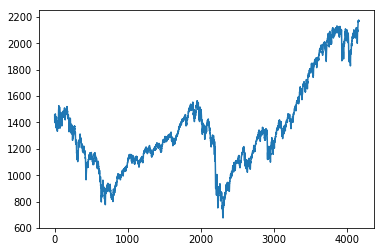

In [8]:
# Have a gander at the stock data. As you can see, the overall trend is upwards
plt.plot(raw_data[0])

In [9]:
# Determine how much the simple buy and hold will appreciate over the time frame
stock_ary = raw_data[0].values
buy_and_hold = stock_ary[-1] / stock_ary[0]
print(buy_and_hold)

1.49176078618


In [10]:
# Calc average return for basic buy and hold strategy over each mini-epoch period
avg_return = buy_and_hold** (mini_epoch_size / len(x_train))
print(avg_return)

1.01097565669


In [11]:
# Create our ensemble
bots = [TheWimp(),
        BuyHold(roi=avg_return),
        TheMonkey(),
        TheBull(),
        TheBear(),
        StratBull(),
        StratBear()]

num_bandits = len(bots)

In [12]:
#init our agent

tf.reset_default_graph()

#These two lines established the feed-forward part of the network. 
#This does the actual choosing.
weights = tf.Variable(tf.ones([num_bandits]))
chosen_action = tf.argmax(weights,0)

#The next six lines establish the training proceedure. 
#We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
responsible_weight = tf.slice(weights,action_holder,[1])
loss = -(tf.log(responsible_weight)*reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
update = optimizer.minimize(loss)

## Reinforcement training
I will use the stock reinforcement training protocol pretty much as is. All I've done is substituted the function `pullBandit()` with a call to the active bot's main function. 

In [13]:


sample_ratio = total_episodes / mini_epoch_size
print('Mini-epoch size: {}\nNum Mini-epochs: {}'.format(mini_epoch_size, total_episodes // mini_epoch_size))
total_reward = np.zeros(num_bandits) #Set scoreboard for bandits to 0.
e = 0.2 #Set the chance of taking a random action.

init = tf.initialize_all_variables()
verbose_updates = False
# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    for i in tqdm(range(total_episodes)):
#         print('Ep {} of {}'.format(i, total_episodes))
        
        
        tp = np.random.randint(0, len(x_train))
        x = x_train[tp].ravel() # select time period
        
        #Choose either a random action or one from our network.
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        
#         reward = pullBandit(bandits[action]) #Get our reward from picking one of the bandits.
        reward = bots[action](x) #Get our reward from picking one of the bandits.
        

        #Update the network.
        _,resp,ww = sess.run([update,responsible_weight,weights], feed_dict={reward_holder:[reward],action_holder:[action]})
        
        #Update our running tally of scores.
        total_reward[action] += reward
        
        if i % print_epoch_size == 0 and verbose_updates:
            print('Results: ', ' '.join(['{:.3f}'.format(bot.p) for bot in bots]))
            print("Running reward: {}".format(str(total_reward)))
        if i % mini_epoch_size == 0:
            [bot.reset() for bot in bots]
winner = np.argmax(ww)
print("The agent thinks bandit {} is the most promising....".format(bots[winner].name))


Mini-epoch size: 100
Num Mini-epochs: 1000
Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 100000/100000 [00:48<00:00, 2046.94it/s]

The agent thinks bandit BuyAndHold is the most promising....


### Let's see how they performed
I normalized the score, since it's roughly proportional to the total number of episodes. This score is only a relative indicator, it does not tell us what our ROI would be.

In [14]:
for i, bot in enumerate(bots):
    star = '*' if i == winner else ''
    print('{: >10}: {: >+10.3f} {}'.format(bot.name, 1000*total_reward[i]/total_episodes, star))


   TheWimp:     -0.145 
BuyAndHold:     +4.903 *
 TheMonkey:     +0.129 
   TheBull:     +0.933 
   TheBear:     -1.586 
 StratBull:     +0.321 
 StratBear:     -0.100 


### A winner is ~~you~~ Buy and Hold! (at least for this seed value)
#### Looks like (for total_episodes > 100,000), the tried-and true method wins. That's pretty cool, but we had to use quite a large number of episodes to get a stable result. I've observed with this technique, there is somewhat of an effect of 'early winner takes all'. With lower numbers of runs, the model which by chance gets a bit of an advantage tends to pull out way ahead. What if we just run all models in parallel, do we see the same results?

In [15]:
print('Mini-epoch size: {}\nNum Mini-epochs: {}'.format(mini_epoch_size, total_episodes // mini_epoch_size))
total_reward = np.zeros(num_bandits) #Set scoreboard for bandits to 0.

init = tf.initialize_all_variables()
verbose_updates = False
# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
   
    for i in tqdm(range(total_episodes)):
        tp = np.random.randint(0, len(x_train))
        x = x_train[tp].ravel() # select time period
        for action in range(len(bots)):
            reward = bots[action](x) #Get our reward from picking one of the bandits.

            #Update our running tally of scores.
            total_reward[action] += reward

        if i % print_epoch_size == 0 and verbose_updates:
            print('Results: ', ' '.join(['{:.3f}'.format(bot.p) for bot in bots]))
            print("Running reward: {}".format(str(total_reward)))
        if i % mini_epoch_size == 0:
            [bot.reset() for bot in bots]
    
winner = np.argmax(total_reward)
print("The agent thinks {} is the most promising....".format(bots[winner].name))

Mini-epoch size: 100
Num Mini-epochs: 1000
Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 100000/100000 [00:04<00:00, 22911.23it/s]

The agent thinks TheBull is the most promising....


In [16]:
for i, bot in enumerate(bots):
    star = '*' if i == winner else ''
    print('{: >10}: {: >+10.3f} {}'.format(bot.name, 10*total_reward[i]/total_episodes, star))

   TheWimp:     -0.050 
BuyAndHold:     +0.059 
 TheMonkey:     +2.672 
   TheBull:    +13.227 *
   TheBear:     -7.492 
 StratBull:     +5.488 
 StratBear:     -0.831 


#### Now it seems to favor the Bull over the Buy and Hold. Interesting. 
This is likely because the Bull strategy is more heavily hit by market fluctuations, which the Reinforcement Learning paradigm picks up on, and penalizes. However, if we take away that hysteresis effect (think of it as a 'bailout' each time we lose money), the Bull has a slight advantage, since it isn't really penalized by past losses as well. 

### I'm calling that successful reinforcement learning!

So, at least with these really simple models, you can't beat the sound advice of invest your money and DON'T TOUCH IT. I'll catch up with you wizards in my penthouse...30 years from now ;)
![pig](images/piggy.jpg)